# DINO: Self-attention mapの可視化
https://github.com/facebookresearch/dino および https://github.com/facebookresearch/dino/blob/main/visualize_attention.py を元に作成．

## Setup

In [8]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
import os
import sys
REPO_PATH = "/home/osero/Desktop/CMPE/dinov2" # Specify a local path to the repository (or use installed package instead)
sys.path.append(REPO_PATH)

## torch Hubからのモデルの読み込み

In [9]:
patch_size = 8
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14")

Using cache found in /home/osero/.cache/torch/hub/facebookresearch_dinov2_main


In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [11]:
for p in model.parameters():
        p.requires_grad = False
model.eval()
model.to(device)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1):

## 入力画像の読み込み

<class 'PIL.Image.Image'>
(480, 480, 3)


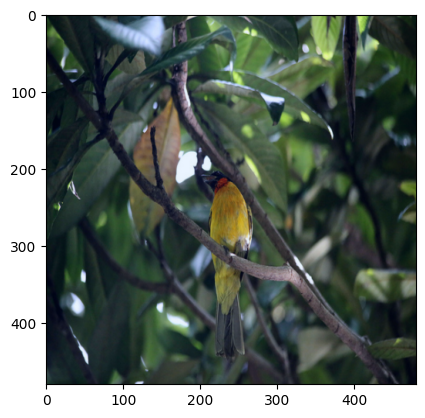

In [12]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img0 = Image.open(BytesIO(response.content))
img0 = img0.convert('RGB')

plt.imshow(img0)
print(type(img0))
print(np.array(img0).shape)

## モデルからのattention mapの取得

In [13]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img0)
print(img.shape)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

#attentions = model.forward_selfattention(img.to(device))
attentions = model.get_last_self_attention(img.to(device))   #img.cuda()
print(attentions.shape)

torch.Size([3, 480, 480])


AttributeError: 'DinoVisionTransformer' object has no attribute 'get_last_self_attention'

In [ ]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

In [ ]:
threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

## Attention mapの可視化

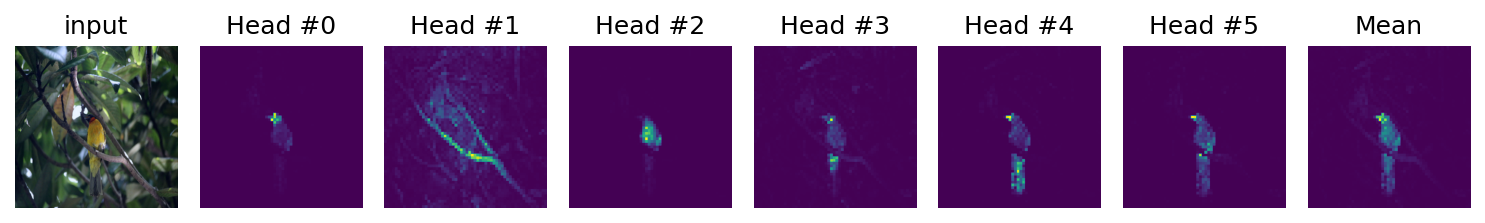

In [ ]:
plt.figure(figsize=(10, 3), dpi=150)
plt.subplot(1, nh+2, 1)
plt.title("input")
plt.imshow(img_npy)
plt.axis("off")
# visualize self-attention of each head

for i in range(nh):
  plt.subplot(1, nh+2, i+2)
  plt.title("Head #"+str(i))
  plt.imshow(attentions[i])
  plt.axis("off")

plt.subplot(1, nh+2, nh+2)
plt.title("Mean")
plt.imshow(attentions_mean)
plt.axis("off")
plt.tight_layout()